<a href="https://colab.research.google.com/github/s2moon98/wtte-rnn-CGM/blob/main/wtte-rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Maintenance for the Turbofan Engine Dataset


## Data Preparation

In [1]:
import keras
import keras.backend as K

print ("Keras version", keras.__version__)

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.optimizers import Nadam

# Setting seed for reproducibility
SEED = 42
np.random.seed(SEED)  

Keras version 2.4.3


In [2]:
!mkdir Dataset
!mkdir Models

!wget -q https://raw.githubusercontent.com/Manelmc/rnn-time-to-event/master/Dataset/PM_test.txt -O Dataset/PM_test.txt 
!wget -q https://raw.githubusercontent.com/Manelmc/rnn-time-to-event/master/Dataset/PM_train.txt -O Dataset/PM_train.txt  
!wget -q https://raw.githubusercontent.com/Manelmc/rnn-time-to-event/master/Dataset/PM_truth.txt -O Dataset/PM_truth.txt
  
!ls Dataset

PM_test.txt  PM_train.txt  PM_truth.txt


### Turbofan Train Set

In [ ]:
pwd

'/content'

### Turbofan Test Set

In [4]:
from sklearn import preprocessing

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('Dataset/1_19_train_set.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[5, 6]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 's1', 's2', 's3']

train_df = train_df.sort_values(['id','cycle'])

# Data Labeling - generate column RUL (Remaining Useful Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2', 'label3'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df[train_df["id"] == 1].tail()

,id,cycle,s1,s2,s3,RUL,cycle_norm
275,1,276,0.084986,0.0,0.004452,4,0.916667
276,1,277,0.082153,0.0,0.004240,3,0.920000
277,1,278,0.084986,0.0,0.004240,2,0.923333
278,1,279,0.079320,0.0,0.004240,1,0.926667
279,1,280,0.070822,0.0,0.004040,0,0.930000


In [5]:
from sklearn import preprocessing

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv('Dataset/4p_test_set.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[5, 6]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 's1', 's2', 's3']

# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv('Dataset/PM_truth.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

test_df[test_df["id"] == 1].tail()

,id,cycle,s1,s2,s3,cycle_norm,RUL
208,1,209,0.118980,0.0,0.123231,0.693333,116.0
209,1,210,0.116147,0.0,0.123231,0.696667,115.0
210,1,211,0.110482,0.0,0.108042,0.700000,114.0
211,1,212,0.099150,0.0,0.108042,0.703333,113.0
212,1,213,0.073654,0.0,0.108042,0.706667,112.0


### Apply right padding to all the sequences

In [6]:
def pad_sequence(df, max_seq_length, mask=0):
    """
    Applies right padding to a sequences until max_seq_length with mask 
    """
    return np.pad(df.values, ((0, max_seq_length - df.values.shape[0]), (0,0)), 
                  "constant", constant_values=mask)
  
def pad_engines(df, cols, max_batch_len, mask=0):
    """
    Applies right padding to the columns "cols" of all the engines 
    """
    return np.array([pad_sequence(df[df['id'] == batch_id][cols], max_batch_len, mask=mask) 
                     for batch_id in df['id'].unique()])
  
max_batch_len = train_df['id'].value_counts().max()
train_cols = ['s' + str(i) for i in range(1,4)] + ['cycle_norm']
test_cols = ["RUL"]

X = pad_engines(train_df, train_cols, max_batch_len)
Y = pad_engines(train_df, test_cols, max_batch_len)

### Split into train, validation and test

In [7]:
from sklearn.model_selection import train_test_split

# Split into train and validation
train_X, val_X, train_Y, val_Y = train_test_split(X, Y, test_size=0.20, random_state=SEED)

# Test set from CMAPSS
test_X = pad_engines(test_df, train_cols, max_batch_len)
test_Y = pad_engines(test_df, test_cols, max_batch_len)

# In the WTTE-RNN architecture we will predict 2 parameters (alpha and beta)
# alpha is initialised to 1
train_Y_wtte = np.concatenate((train_Y, np.ones(train_Y.shape)), axis=2)
val_Y_wtte = np.concatenate((val_Y, np.ones(val_Y.shape)), axis=2)
test_Y_wtte = np.concatenate((test_Y, np.ones(test_Y.shape)), axis=2)

print ("Train:\n", "  X:", train_X.shape, "\n  Y:", train_Y.shape, "\n  Y_wtte:", train_Y_wtte.shape)
print ("\nValidation:\n", "  X:", val_X.shape, "\n  Y:", val_Y.shape, "\n  Y_wtte:", val_Y_wtte.shape)
print ("\nTest:\n", "  X:", test_X.shape, "\n  Y:", test_Y.shape, "\n  Y_wtte:", test_Y_wtte.shape)

Train:
   X: (124, 301, 4) 
  Y: (124, 301, 1) 
  Y_wtte: (124, 301, 2)

Validation:
   X: (32, 301, 4) 
  Y: (32, 301, 1) 
  Y_wtte: (32, 301, 2)

Test:
   X: (131, 301, 4) 
  Y: (131, 301, 1) 
  Y_wtte: (131, 301, 2)


## Baseline

In [8]:
from keras.layers import Masking
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model path
baseline_path = "baseline_model"

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=30, 
                               verbose=0, 
                               mode='min')
checkpoint = ModelCheckpoint(baseline_path, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='min', 
                             verbose=0)
# dimensions of the model
nb_features = train_X.shape[2]
nb_out = train_Y.shape[2]

model = Sequential()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 301, 4)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 301, 100)          42000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 301, 50)           30200     
_________________________________________________________________
time_distributed (TimeDistri (None, 301, 1)            51        
Total params: 72,251
Trainable params: 72,251
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
1/1 - 9s - loss: 15910.3477 - val_loss: 18162.5273
INFO:tensorflow:Assets written to: baseline_model/assets
Epoch 2/3
1/1 - 2s - loss: 15851.1357 - val_loss: 17825.2812
INFO:tensorflow:Assets written to: baseline_model/assets
Epoch 3

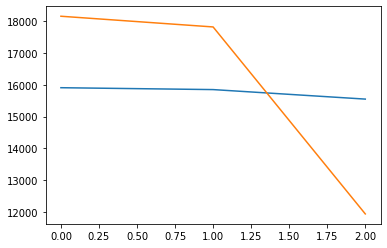

In [9]:
from keras.layers import Masking
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Model path
baseline_path = "baseline_model"

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=30, 
                               verbose=0, 
                               mode='min')
checkpoint = ModelCheckpoint(baseline_path, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             mode='min', 
                             verbose=0)
# dimensions of the model
nb_features = train_X.shape[2]
nb_out = train_Y.shape[2]

model = Sequential()
# Masking layer so the right padding is ignored 
# at each layer of the network 
model.add(Masking(mask_value=0., 
                  input_shape=(max_batch_len, nb_features)))
# Then there s an LSTM layer with 100 units 
# Recurrent Dropout is also applied after each 
# LSTM layer to control overfitting. 
model.add(LSTM(
         units=100,
         recurrent_dropout=0.2,
         return_sequences=True))
# followed by another LSTM layer with 50 units
model.add(LSTM(
         units=50,
         recurrent_dropout=0.2,
         return_sequences=True))
# Final layer is a Time-Distributed Dense layer
# with a single unit with an Exponential activation
model.add(TimeDistributed(Dense(nb_out, activation=K.exp)))
model.compile(loss="mse", optimizer=keras.optimizers.RMSprop())

print(model.summary())

# fit the network
history = model.fit(train_X, train_Y, epochs=3, batch_size=200, 
                    validation_data=(val_X, val_Y), shuffle=True, 
                    verbose=2, callbacks = [early_stopping, checkpoint])

# list all data in history
print(history.history.keys())
%matplotlib inline
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [10]:
#keras model h5형태로 저장
from keras.models import load_model

model.save('wtte-rnn.h5')

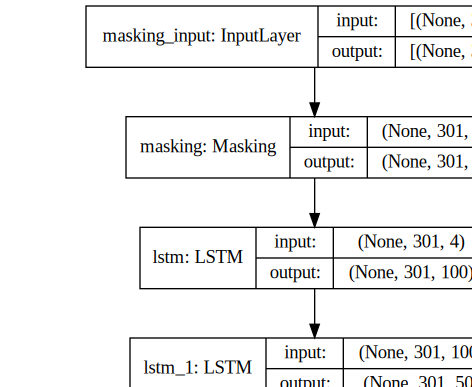

In [11]:
#h5로 keras model 내부 구조 출력
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
import tensorflow as tf

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpudwo56jx/assets


In [ ]:
# Execute if training in Colaboratory (preferably from Chrome)
# Downloads the model after the training finishes

#from google.colab import files
#files.download(baseline_path)

# Move the model to the expected folder
# !mv baseline_path Models/

NameError: ignored

In [ ]:
# Validation loss vs the Training loss

#%matplotlib inline

#history = model.fit(train_X, train_Y, epochs=500, batch_size=16, 
#                    validation_data=(val_X, val_Y), shuffle=True, 
#                    verbose=2, callbacks = [early_stopping, checkpoint])

#plt.plot(history.history["loss"])
#plt.plot(history.history["val_loss"])

In [ ]:
#model.save("model.h5")

In [ ]:
# Execute if you want to upload a model to Collaboratory

#from google.colab import files
#uploaded = files.upload()

#for fn in uploaded.keys():
#    print('User uploaded file "{name}" with length {length} bytes'.format(
#      name=fn, length=len(uploaded[fn])))

In [ ]:
#from tensorflow.keras.models import load_model

# It's important to load the model after the training
# The keras Checkpoint will save the best model in terms
# of the validation loss in the specified path
# model = load_model('Models/baseline_model')

ValueError: ignored

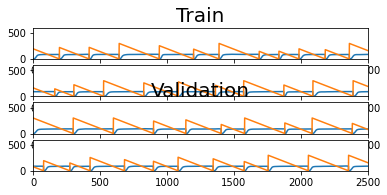

In [ ]:
%matplotlib inline
from math import sqrt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# We save the validation errors to later compare the models
validation_baseline = model.predict(val_X).flatten()

def evaluate_and_plot(model, evaluation_data, weibull_function=None):
    """
    Generate scores dataframe and plot the RUL
    """
    fig = plt.figure()
    i = 1
    score_df = pd.DataFrame({"Method": ["MAE", "RMSE", "R2"]})
    for name_set, train_set, test_set in evaluation_data:
        if weibull_function is None:
            y_pred = model.predict(train_set).flatten()
        else:
            y_pred = [weibull_function(alpha, beta) 
                      for batch in model.predict(train_set) 
                      for beta, alpha in batch]
        l = test_set[:,:,0].flatten()
        # To validate we remove the right padding
        y_true = np.ma.compressed(np.ma.masked_where(l==0, l))
        y_pred = np.ma.compressed(np.ma.masked_where(l==0, y_pred))
        score_mae = "{0:.2f}".format(mean_absolute_error(y_true, y_pred))
        score_rmse = "{0:.2f}".format(sqrt(mean_squared_error(y_true, y_pred)))
        score_r2 = "{0:.3f}".format(r2_score(y_true, y_pred))
        score_df[name_set] = [score_mae, score_rmse, score_r2]
        ax = fig.add_subplot(6, 1, i)
        ax.title.set_text(name_set)
        ax.title.set_fontsize(20)
        i += 1
        plt.plot(y_pred[0:2500])
        plt.plot(y_true[0:2500])
        plt.axis([0,2500,0,600])
        ax = fig.add_subplot(6, 1, i)
        i += 1
        plt.plot(y_pred[2500:5000])
        plt.plot(y_true[2500:5000])
        plt.axis([0,2500,0,600])
    plt.subplots_adjust(hspace=0.45)
    plt.axis([0,2500,0,600])
    fig.set_size_inches(15, i*2.2)
    return score_df.T

evaluate_and_plot(model,
                  [("Train", train_X, train_Y), 
                   ("Validation", val_X, val_Y), 
                   ("Test", test_X, test_Y)])

## Adapting to WTTE-RNN

In [ ]:
# Install wtte package from Martinsson

!pip install wtte

ERROR: tensorflow 2.4.1 has requirement six~=1.15.0, but you'll have six 1.10.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.15.0, but you'll have six 1.10.0 which is incompatible.
ERROR: google-api-python-client 1.12.8 has requirement six<2dev,>=1.13.0, but you'll have six 1.10.0 which is incompatible.
ERROR: google-api-core 1.26.1 has requirement six>=1.13.0, but you'll have six 1.10.0 which is incompatible.
ERROR: dm-tree 0.1.5 has requirement six>=1.12.0, but you'll have six 1.10.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0


In [ ]:
# Loss and activation functions from Martinsson
# These are not used in the final version because 
# the wtte package has useful regularization tools

def weibull_loglik_discrete(y_true, y_pred, epsilon=K.epsilon()):
    y = y_true[..., 0]
    u = y_true[..., 1]
    a = y_pred[..., 0]
    b = y_pred[..., 1]
    
    hazard0 = K.pow((y + epsilon) / a, b)
    hazard1 = K.pow((y + 1.0) / a, b)

    loss = u * K.log(K.exp(hazard1 - hazard0) - (1.0 - epsilon)) - hazard1
    return -loss

def activation_weibull(y_true):
    a = y_true[..., 0]
    b = y_true[..., 1]
    
    a = K.exp(a)
    b = K.sigmoid(b)
    return K.stack([a, b], axis=-1)

In [ ]:
from keras.layers import Masking
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Lambda
from keras.callbacks import EarlyStopping, TerminateOnNaN, ModelCheckpoint
import wtte.weibull as weibull
import wtte.wtte as wtte

# Since we use a lambda in the last layer the model 
# is not saved well in keras, instead we save the weights.
# This requires compiling the model to load the weights
baseline_wtte_path = "baseline_wtte_model_weights"
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=30, 
                               verbose=0, 
                               mode='min')
checkpoint = ModelCheckpoint(baseline_wtte_path, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=0)

nb_features = train_X.shape[2]
nb_out = train_Y.shape[1]

model = Sequential()

model.add(Masking(mask_value=0.,
                  input_shape=(max_batch_len, nb_features)))
model.add(LSTM(
         input_shape=(None, nb_features),
         units=50,
         recurrent_dropout=0.01,
         return_sequences=True))
model.add(LSTM(
         input_shape=(None, nb_features),
         units=40,
         recurrent_dropout=0.01,
         return_sequences=True))
model.add(LSTM(
         input_shape=(None, nb_features),
         units=30,
         recurrent_dropout=0.01,
         return_sequences=True))

model.add(TimeDistributed(Dense(2)))
# uncomment this line and comment the next to use 
#activation_weibull function:
#model.add(Activation(activation_weibull))
model.add(Lambda(wtte.output_lambda, 
                 arguments={# Initialization value around it's scale
                            "init_alpha": np.nanmean(train_Y_wtte[:,0]), 
                            # Set a maximum
                            "max_beta_value": 10.0
                           },
                ))
# Same for the loss "weibull_loglik_discrete"
# model.compile(loss=weibull_loglik_discrete, optimizer='rmsprop')
# We use clipping on the loss
loss = wtte.Loss(kind='discrete', clip_prob=1e-5).loss_function


# 옵타마이저 참고 : https://wikidocs.net/36033
# 현아 : RMS 쓸거면
#model.compile(loss=loss, optimizer=RMSprop(lr=0.05, rho=0.9, epsilon=1e-06))
#model.compile(loss=loss, optimizer='rmsprop')

# 현아 : Nadam 쓸거면
#model.compile(loss=loss,optimizer=Nadam(lr=0.05,beta_1=0.9,beta_2=0.999,epsilon=1e-08,schedule_decay=0.004))

# 현아 : Adam 쓸거면
model.compile(loss=loss, optimizer=Adam(lr=0.05, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=False))

# 영석 : 로그라이크,,?
#model.compile(loss=weibull_loglik_discrete, optimizer=RMSprop(lr=0.1, rho=0.9, epsilon=1e-06))


In [ ]:
print(model.summary())

# fit the network
history = model.fit(train_X, train_Y_wtte, epochs=48, batch_size=200, 
                    validation_data=(val_X, val_Y_wtte), shuffle=True, verbose=2,
                    callbacks = [early_stopping, checkpoint, TerminateOnNaN()])

# list all data in history
print(history.history.keys())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_4 (Masking)          (None, 311, 4)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 311, 50)           11000     
_________________________________________________________________
lstm_10 (LSTM)               (None, 311, 40)           14560     
_________________________________________________________________
lstm_11 (LSTM)               (None, 311, 30)           8520      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 311, 2)            62        
_________________________________________________________________
lambda_3 (Lambda)            (None, 311, 2)            0         
Total params: 34,142
Trainable params: 34,142
Non-trainable params: 0
__________________________________________________

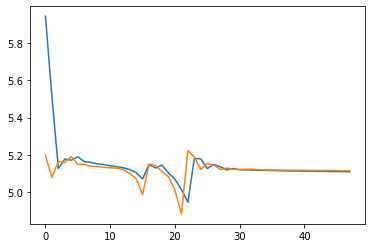

In [ ]:
%matplotlib inline


plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [ ]:
# Compile model first to load weights

model.load_weights("baseline_wtte_model_weights")

### Weibull Methods

$\mu = \beta\Gamma(1 + \alpha^{-1})$

$\sigma^2 = \beta^2[\Gamma(1 + 2\alpha^{-1}) - \Gamma^2(1 + \alpha^{-1})]$

$mode = \beta\frac{\alpha-1}{\alpha}^{1/\alpha}$

Inverse CDF $ = \beta (-\log(1 - x))^\frac{1}{\alpha} $ when $ 0<x<1 $

In [ ]:
from math import gamma, log, sqrt

def mean_weibull(alpha, beta):
    return beta*gamma(1 + 1./alpha)

def mode_weibull(alpha, beta):
    return beta*((alpha-1)/alpha)**(1./alpha) if alpha > 1 else 0

def median_weibull(alpha, beta):
    return beta*(log(2)**(1./alpha))

def var_weibull(alpha, beta):
    return beta**2*(gamma(1 + 2./alpha) - gamma(1 + 1./alpha)**2)

def pdf_weibull(x, alpha, beta):
    return (alpha/beta)*(x/beta)**(alpha - 1)*np.exp(-(x/beta)**alpha)

def inverse_cdf_weibull(x, alpha, beta):
    return beta*np.power((-np.log(1.-x)), 1./alpha)

def survival_weibull(x, alpha, beta):
    return np.e**-((x/beta)**alpha)

### Mean, Mode and Median



![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Visualisation_mode_median_mean.svg/150px-Visualisation_mode_median_mean.svg.png)

Mode
                 0       1       2
Method         MAE    RMSE      R2
Train       122.02  143.87  -2.563
Validation  119.60  140.77  -2.595
Test        116.93  137.32  -2.637

Median
                0      1      2
Method        MAE   RMSE     R2
Train       57.50  73.09  0.080
Validation  54.78  70.30  0.104
Test        50.12  64.78  0.191

Mean
                0       1       2
Method        MAE    RMSE      R2
Train       61.53  160.86  -3.454
Validation  62.45  163.19  -3.831
Test        67.70  159.97  -3.936


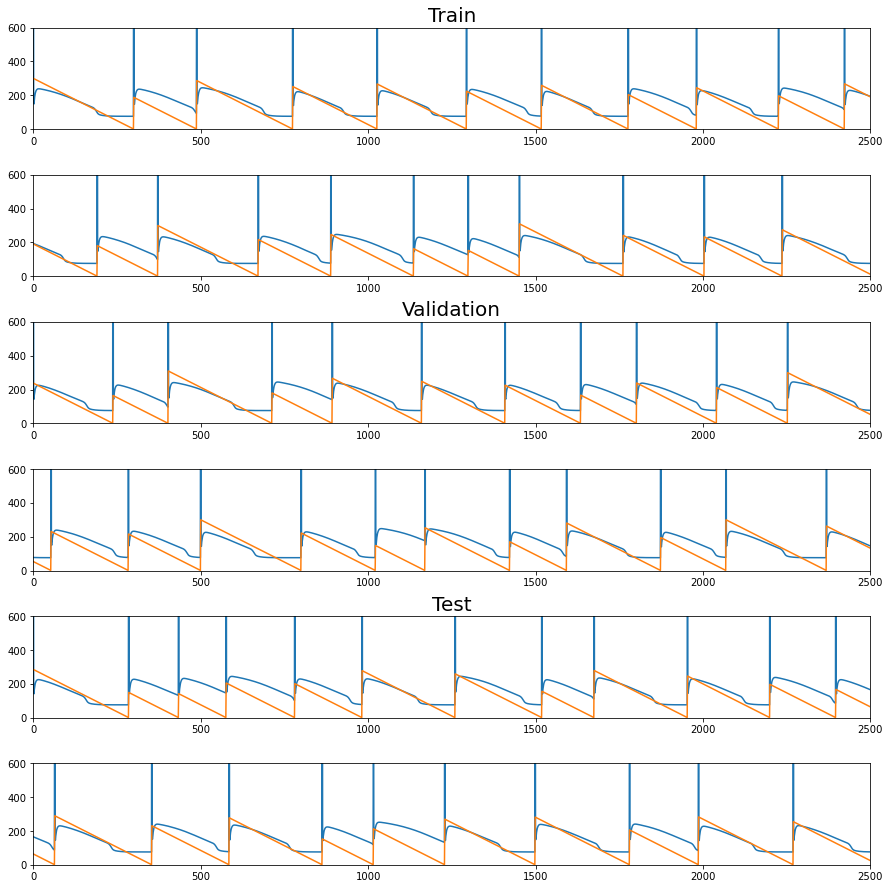

In [ ]:
%matplotlib inline

print("Mode")
print (evaluate_and_plot(model,
                        [("Train", train_X, train_Y_wtte), 
                         ("Validation", val_X, val_Y_wtte), 
                         ("Test", test_X, test_Y_wtte)],
                        weibull_function = mode_weibull))

# comment the next line to visualise the plot for the mode
plt.close()

print("\nMedian")
print (evaluate_and_plot(model,
                        [("Train", train_X, train_Y_wtte), 
                         ("Validation", val_X, val_Y_wtte), 
                         ("Test", test_X, test_Y_wtte)],
                        weibull_function = median_weibull))

# comment the next line to visualise the plot for the median
plt.close()

# We save the validation errors to later compare the models
validation_wtte = [mean_weibull(alpha, beta) 
                   for batch in model.predict(val_X) 
                   for beta, alpha in batch]

print("\nMean")
print(evaluate_and_plot(model,
                        [("Train", train_X, train_Y_wtte), 
                         ("Validation", val_X, val_Y_wtte), 
                         ("Test", test_X, test_Y_wtte)],
                        weibull_function = mean_weibull))

### Evolution of the pdf through the cycles of an engine (PLOT)

In [ ]:
import random

import seaborn as sns


random.seed(SEED)
lot = random.sample(train_X, 3) 
random.seed(SEED)
lot += random.sample(val_X, 3)
random.seed(SEED)
lot += random.sample(test_X, 3)

palette = list(reversed(sns.color_palette("RdBu_r", 250)))

fig = plt.figure()
j = 1
for batch in lot:
    size = batch[~np.all(batch == 0, axis=1)].shape[0]
    y_pred_wtte = model.predict(batch.reshape(1, max_batch_len, nb_features))[0]
    y_pred_wtte = y_pred_wtte[:size]
    x = np.arange(1, 400.)
    
    freq = 5
    ax = fig.add_subplot(3, 3, j)
    
    i=0
    for beta, alpha in y_pred_wtte[0::freq][2:]:
        mean = mode_weibull(alpha, beta)
        color=palette[int(mean)] if i < len(palette) else palette[-1]
        plt.plot(x, pdf_weibull(x, alpha, beta), color=color)
        i += 1
    ax.set_ylim([0, 0.07])
    ax.set_xlim([0, 300])
    ax.set_yticklabels([])
    if j == 2:
        ax.title.set_text("Train")
    elif j == 5:
        ax.title.set_text("Validation")
    elif j == 8:
        ax.title.set_text("Test")
    j += 1

plt.subplots_adjust(wspace=0.15, hspace=0.25)
fig.set_size_inches(10,10)

### Confidence Interval of the Weibull Distribution

In [ ]:
%matplotlib inline

from scipy.stats import dweibull

batch = lot[0]
size = batch[~np.all(batch == 0, axis=1)].shape[0]
y_pred_wtte = model.predict(batch.reshape(1, max_batch_len, nb_features))[0]
y_pred_wtte = y_pred_wtte[:size]

fig = plt.figure()
fig.add_subplot(1,1,1)
for beta, alpha in y_pred_wtte[0::20]:
    x = np.arange(1, 300.)
    mean = mean_weibull(alpha, beta)
    sigma = np.sqrt(var_weibull(alpha, beta))
    plt.plot(x, pdf_weibull(x, alpha, beta), color=palette[int(mean)])
    # alpha is the shape parameter
    conf = dweibull.interval(0.95, alpha, loc=mean, scale=sigma)
    plt.fill([conf[0]] + list(np.arange(conf[0], conf[1])) + [conf[1]], 
             [0] + list(pdf_weibull(np.arange(conf[0], conf[1]), alpha, beta)) + [0], 
             color=palette[int(mean)], alpha=0.5)

axes = plt.gca()
axes.set_ylim([0., 0.06])
axes.set_xlim([0., 300.])
fig.set_size_inches(10,5)

### Evolution of the pdf through the cycles of an engine (GIFs)

In [ ]:
import sys
import random
from math import gamma

from matplotlib.animation import FuncAnimation
from scipy.stats import dweibull


def generate_gif(y_pred, y_true, path, freq=2):
    # remove mask if exists 
    y_true = y_true[y_true != 0]
    y_pred = y_pred[:y_true.shape[0]]

    frames = zip(y_true, y_pred)

    # pad, w_pad, h_pad, and rect
    fig = plt.figure()
    global ax1, ax2
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)
    fig.set_tight_layout(True)
    x = np.arange(1, 300.)
    beta, alpha = y_pred[0]
    line1, = ax1.plot(x, pdf_weibull(x, alpha, beta))
    global i, acc_y_true, acc_y_pred
    i = 0
    predict_mean = mean_weibull(alpha, beta)
    ax2.plot(i, y_true[0], 'bo', label="True", ms=2.5)
    ax2.plot(i, predict_mean, 'o', color="orange", label="Predicted", ms=2.5)
    ax2.legend(loc="upper right")
    # limits
    ax1.set_ylim([0, 0.07])
    ax2.set_ylim([0, y_true[0] + 10])
    ax2.set_xlim([0, len(frames)/freq + 2])
    ax2.set_xticklabels([])
    # acc values
    acc_y_true = []
    acc_y_pred = []
    
    def update(instant):
        y_true_t, y_pred_t = instant
        beta, alpha = y_pred_t
        # print y_true
        pdf = pdf_weibull(x, alpha, beta)
        line1.set_ydata(pdf)
        global i, acc_y_true, acc_y_pred
        i += 1
        mean = mean_weibull(alpha, beta)
        sigma = np.sqrt(var_weibull(alpha, beta))
        acc_y_pred += [mean]
        acc_y_true += [y_true_t]
        ax2.plot(range(len(acc_y_true)), acc_y_true, 'b', label="True")
        ax2.plot(range(len(acc_y_pred)), acc_y_pred, color="orange", label="Predicted")
        conf = dweibull.interval(0.95, alpha, loc=mean, scale=sigma)
        ax1.set_title("PDF Weibull Distrib. (Mean: " + "{0:.1f}".format(mean)
                     + ", Std: " + "{0:.1f}".format(sigma) + ")"
                     + " CI 95%: [{0:.1f}, {1:.1f}]".format(*conf))
        ax2.set_title("Real RUL: " + str(y_true_t) + " cycles")

    fig.set_size_inches(15,4)
    anim = FuncAnimation(fig, update, frames=frames[0::freq])
    anim.save(path, writer="imagemagick")
    plt.close()

random.seed(SEED)
batch_X, batch_Y = random.choice(zip(train_X, train_Y))
y_pred_wtte = model.predict(batch_X.reshape(1, max_batch_len, nb_features))[0]
gif_path = "Images/train_engine_sample.gif"
generate_gif(y_pred_wtte, batch_Y, gif_path, freq=2)

print "Train Sample"
from IPython.display import HTML
HTML('<img src="'+ gif_path + '">')

In [ ]:
random.seed(SEED)
batch_X, batch_Y = random.choice(zip(val_X, val_Y))
y_pred_wtte = model.predict(batch_X.reshape(1, max_batch_len, nb_features))[0]
gif_path = "Images/val_engine_sample.gif"
generate_gif(y_pred_wtte, batch_Y, gif_path, freq=2)

print "Validation Sample"
from IPython.display import HTML
HTML('<img src="'+ gif_path + '">')

In [ ]:
random.seed(SEED)
batch_X, batch_Y = random.choice(zip(test_X, test_Y))
y_pred_wtte = model.predict(batch_X.reshape(1, max_batch_len, nb_features))[0]
gif_path = "Images/test_engine_sample.gif"
generate_gif(y_pred_wtte, batch_Y, gif_path, freq=2)

print "Test Sample"
from IPython.display import HTML
HTML('<img src="'+ gif_path + '">')

## GRU variant

In [ ]:
from keras.layers import Masking
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, GRU, TimeDistributed, Lambda
from keras.callbacks import EarlyStopping, TerminateOnNaN, ModelCheckpoint
import wtte.weibull as weibull
import wtte.wtte as wtte

baseline_gru_path = "baseline_gru_model_weights"

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=0, 
                               patience=30, 
                               verbose=0, 
                               mode='min')
checkpoint = ModelCheckpoint(baseline_gru_path, 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=0)

nb_features = train_X.shape[2]
nb_out = train_Y.shape[1]

init_alpha = np.nanmean(train_Y_wtte[:,0])

model = Sequential()
model.add(Masking(mask_value=0.,
                  input_shape=(max_batch_len, nb_features)))
# We substitute LSTM for GRU
model.add(GRU(
         input_shape=(None, nb_features),
         units=100,
         recurrent_dropout=0.2,
         return_sequences=True))
model.add(GRU(
          units=50,
          recurrent_dropout=0.2,
          return_sequences=True))
model.add(TimeDistributed(Dense(2)))
model.add(Lambda(wtte.output_lambda, 
                 arguments={# Initialization value around it's scale
                            "init_alpha": np.nanmean(train_Y_wtte[:,0]), 
                            # Set a maximum
                            "max_beta_value": 10.0,
                            # We set the scalefactor to avoid exploding gradients
                            "scalefactor": 0.25
                           },
                ))
loss = wtte.Loss(kind='discrete', clip_prob=1e-5).loss_function
model.compile(loss=loss, optimizer='rmsprop')

In [ ]:
print(model.summary())

# fit the network
history = model.fit(train_X, train_Y_wtte, epochs=500, batch_size=16, 
                    validation_data=(val_X, val_Y_wtte), shuffle=True, verbose=2,
                    callbacks = [early_stopping, checkpoint, TerminateOnNaN()])

# list all data in history
print(history.history.keys())

In [ ]:
# Execute if training in Colaboratory (preferably from Chrome)
# Downloads the model after the training finishes

from google.colab import files
files.download(baseline_gru_path)

# Move the model to the expected folder
!mv baseline_gru_path Models/

In [ ]:
%matplotlib inline

plt.plot(history.history["loss"], color="blue")
plt.plot(history.history["val_loss"], color="green")

In [ ]:
# Execute if you want to upload a model to Collaboratory

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
# Compile model first to load weights

model.load_weights("Models/" + baseline_gru_path)

In [ ]:
# We save the validation errors to later compare the models
validation_gru = [mean_weibull(alpha, beta) 
                   for batch in model.predict(val_X) 
                   for beta, alpha in batch]

evaluate_and_plot(model,
                  [("Train", train_X, train_Y_wtte), 
                   ("Validation", val_X, val_Y_wtte), 
                   ("Test", test_X, test_Y_wtte)],
                  weibull_function = mean_weibull)

# Result

The are three models:
- baseline
- baseline WTTE-RNN LSTM
- baseline WTTE-RNN GRU

The mean is used as the expected value of the RUL.

In [ ]:
%matplotlib inline
import seaborn as sns

l = val_Y.flatten()
y_true = np.ma.compressed(np.ma.masked_where(l==0, l))
y_pred_baseline = np.ma.compressed(np.ma.masked_where(l==0, validation_baseline))
y_pred_wtte = np.ma.compressed(np.ma.masked_where(l==0, validation_wtte))
y_pred_gru = np.ma.compressed(np.ma.masked_where(l==0, validation_gru))


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.violinplot([y_pred_baseline - y_true, 
                    y_pred_wtte - y_true,
                    y_pred_gru - y_true])

ax.set_xticklabels([])
plt.figtext(0.21, 0.1, ' Baseline')
plt.figtext(0.480, 0.1, ' Baseline WTTE')
plt.figtext(0.76, 0.1, ' Baseline GRU')

fig.set_size_inches(15, 10)